# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '10-10-2017'
particle = '293-T_0'
channel = '10-20-10_1'
file_index = '0'

base_path = oi_file.data_base_path

oi_vid_file_path = base_path + date + '/' + particle + '/' + channel + '/oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + '/' + particle + '/' + channel + '/oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
res_x = 384
res_y = 112
oi_fps = 250000

oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, oi_fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

In [4]:
print len(oi_events)

1241


##### Load ellipses

In [5]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + '/' + date + '/' + particle + '/' + channel + '/' + file_index + '/ellipses'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

# Load template and create stage

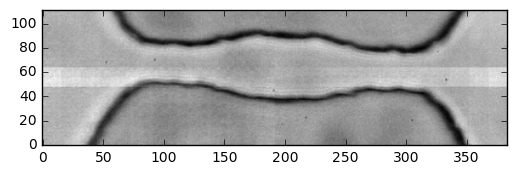

In [6]:
template_index = 100

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.03263567  0.99946731]


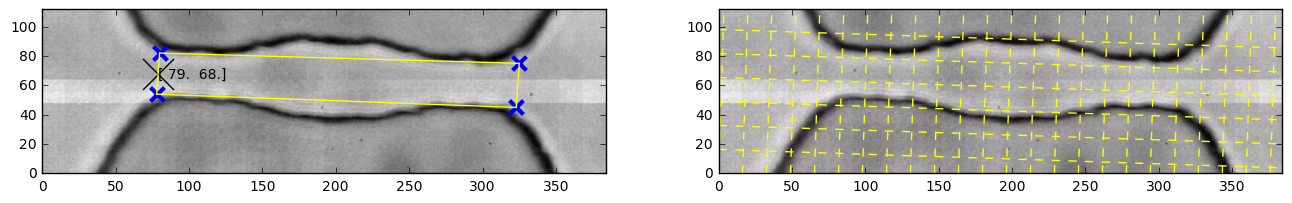

In [7]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)

stage_file_path = base_path + date + '/' + particle + '/' + channel + '/oi/stage/stage_' + file_index
cs = oi.load_stage_file(stage_file_path)

c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Begin filtering

In [8]:
filtering_steps = {}

### Channel enter exit based filtering

In [9]:
keep_indices_enter_exit = []

for i, oi_event in enumerate(oi_events):
    try:
        xs = []
        ys = []

        for j, ellipse in enumerate(ellipsess[i]):
            xs.append(ellipse[1])
            ys.append(ellipse[2])

        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs)
        ycs = oi_stage.pixels_to_meters(ycs)

        if xcs.min() < 0 and xcs.max() > oi_stage._length_microns:
            keep_indices_enter_exit.append(i)
            
    except:
        # Catch-all: Do not append this element to the keep_indices_enter_exit list;
        #            This will prevent it from being analyzed.
        print 'failed on', i
        pass

In [10]:
filtering_steps['channel enter exit'] = [True]

print 'length before', len(oi_events), 'length after', len(keep_indices_enter_exit)
print
print 'events filtered by entrance/exit', [i for i in range(len(ellipsess)) if i not in keep_indices_enter_exit]

length before 1241 length after 1230

events filtered by entrance/exit [47, 69, 87, 157, 165, 395, 590, 783, 1018, 1075, 1127]


## Geometry based filtering

aspect failed on  144
aspect failed on  158
radius failed on  247
aspect failed on  247
aspect failed on  515
radius failed on  668
aspect failed on  668
radius failed on  716
aspect failed on  716
aspect failed on  814
radius failed on  841
aspect failed on  841
aspect failed on  878
radius failed on  1044
aspect failed on  1044
aspect failed on  1087
aspect failed on  1101
aspect failed on  1239


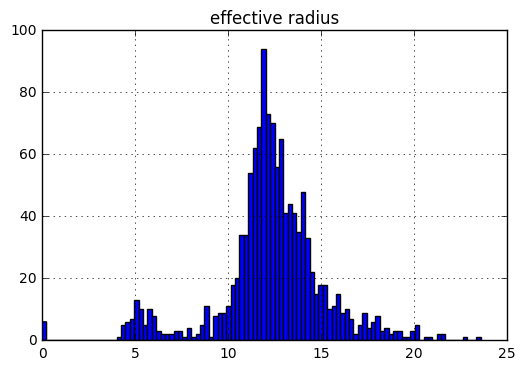

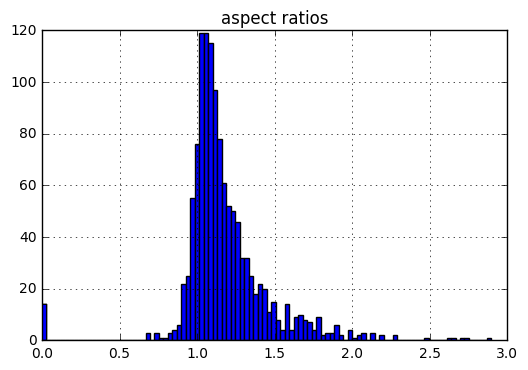

In [11]:
# Define left and right bounds that particle must be between for fitting its radius and aspect
xc_left = 60
xc_right = 90

yc_top = 100
yc_bottom = -100



effective_radii = []
effective_radius_max = 30

aspect_ratios = []
aspect_ratio_max = 3



for i, oi_event in enumerate(oi_events):
  
    aspect_ratio = 0
    effective_radius = 0
    for j, ellipse in enumerate(ellipsess[i]):
        
        x = ellipse[1]
        y = ellipse[2]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        yc = oi_stage.pixels_to_meters(yc)
        
        
        
        
        if xc > xc_left and xc < xc_right and yc > yc_bottom and yc < yc_top:
            
            a = ellipse[3]
            b = ellipse[4]

            
            aspect_ratio = a/b

            effective_radius = np.sqrt(a*b)
        
            break
            
            
    # Catch bad values
    if effective_radius > effective_radius_max or np.isnan(effective_radius) or np.isinf(effective_radius):
        print 'radius failed on ', i
        effective_radius = 0
    
    
    
    if np.isnan(aspect_ratio) or np.isinf(aspect_ratio) or aspect_ratio > aspect_ratio_max:
        print 'aspect failed on ', i
        aspect_ratio = 0
    
    
        
    # Append values to lists        
    effective_radii.append(effective_radius)
    aspect_ratios.append(aspect_ratio)
    
            
plt.close()
plt.hist(effective_radii, bins = 100)
plt.title('effective radius')
plt.grid()
plt.show()
            
plt.hist(aspect_ratios, bins = 100)
plt.title('aspect ratios')
plt.grid()
plt.show()      

## Filter size

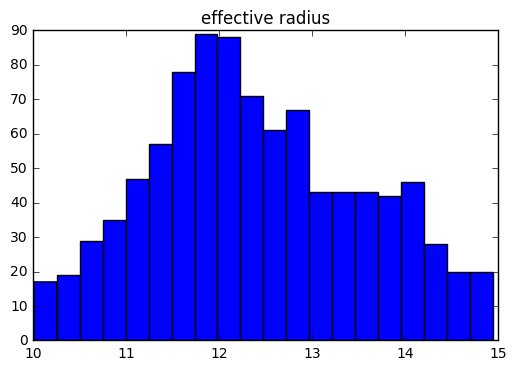

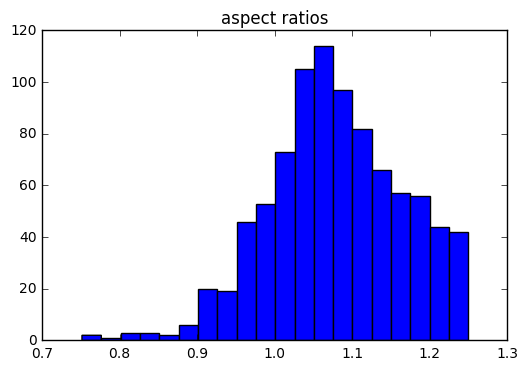

radius filtering 298/1241

retained events (by radius)
[924, 1010, 961, 116, 206, 567, 145, 1208, 1225, 630, 836, 25, 434, 1079, 1071, 107, 658, 548, 1125, 149, 339, 48, 729, 503, 375, 1077, 1040, 1139, 147, 374, 1062, 300, 734, 91, 803, 168, 858, 866, 667, 702, 173, 917, 653, 1127, 1170, 719, 1042, 322, 554, 460, 404, 1095, 1200, 1039, 396, 992, 995, 224, 315, 657, 982, 469, 75, 931, 32, 885, 949, 1014, 273, 638, 152, 179, 786, 3, 909, 1233, 766, 542, 442, 1234, 413, 453, 593, 9, 743, 536, 833, 326, 972, 408, 111, 112, 1193, 578, 526, 534, 74, 1008, 529, 438, 690, 1038, 916, 351, 243, 388, 519, 1203, 169, 230, 577, 99, 49, 461, 1134, 731, 138, 72, 1131, 1191, 744, 696, 1152, 1161, 1050, 1022, 301, 574, 683, 706, 1183, 7, 265, 1210, 429, 810, 512, 159, 1046, 750, 930, 303, 591, 1037, 414, 419, 1051, 1148, 818, 1204, 811, 1081, 800, 38, 15, 127, 478, 6, 71, 448, 1188, 319, 290, 681, 160, 988, 1129, 673, 357, 569, 532, 934, 568, 915, 363, 253, 765, 118, 397, 445, 42, 380, 652, 823, 121, 

In [12]:
# Filter size
radius_min = 10
radius_max = 15

filtering_steps['effective radius'] = [radius_min, radius_max]

keep_indices_radius = [i for i in range(len(effective_radii)) if ((effective_radii[i] > radius_min) and (effective_radii[i] < radius_max))]


# Filter aspect

aspect_min = 0.75
aspect_max = 1.25

filtering_steps['aspect ratio'] = [aspect_min, aspect_max]

keep_indices_aspect = [i for i in range(len(aspect_ratios)) if ((aspect_ratios[i] > aspect_min) and (aspect_ratios[i] < aspect_max))]



# Histograms
plt.hist(np.array(effective_radii)[keep_indices_radius], bins = 20)
plt.title('effective radius')
plt.show()
            
plt.hist(np.array(aspect_ratios)[keep_indices_aspect], bins = 20)
plt.title('aspect ratios')
plt.show()  




# Print

print ('radius filtering ' + str(len(oi_events) - len(keep_indices_radius)) + '/' + str(len(oi_events)))

print

print 'retained events (by radius)\n', [ele for ele in np.argsort(effective_radii) if ele in keep_indices_radius]

print 

print ('aspect ratio filtering ' + str(len(oi_events) - len(keep_indices_aspect)) + '/' + str(len(oi_events)))

print

print 'retained events (by aspect)\n', [ele for ele in np.argsort(aspect_ratios) if ele in keep_indices_aspect]

print

print('events filtered out by size but kept by aspect:')
print([i for i in range(len(oi_events)) if (i in keep_indices_aspect) and (i not in keep_indices_radius)])

print


print('events filtered out by aspect but kept by size:')
print([i for i in range(len(oi_events)) if (i not in keep_indices_aspect) and (i in keep_indices_radius)])

print


    


687
radius: 14.6154810034
aspect: 1.59371374256


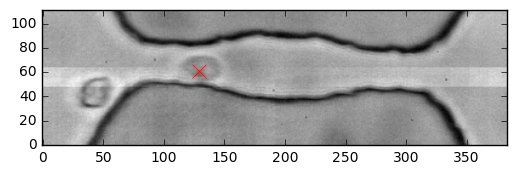

758
radius: 14.6292606283
aspect: 1.27355220207


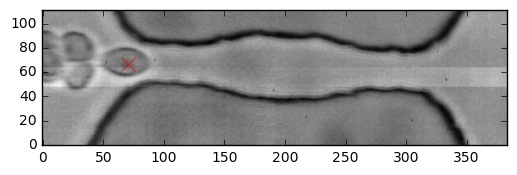

564
radius: 14.6926464858
aspect: 2.07888073674


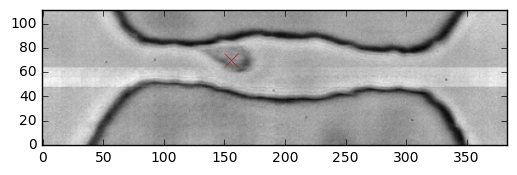

938
radius: 14.6955149105
aspect: 1.16594468503


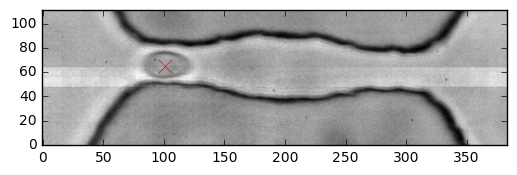

1084
radius: 14.7025187432
aspect: 1.42003595315


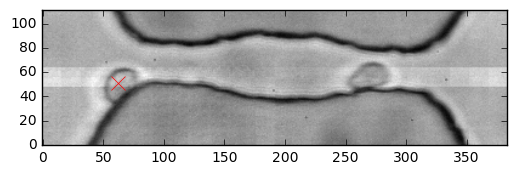

327
radius: 14.7233414836
aspect: 1.10275220316


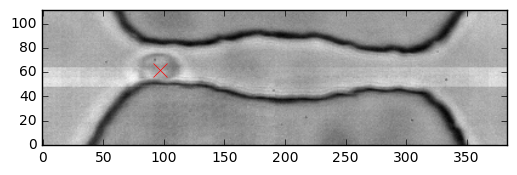

708
radius: 14.7299837595
aspect: 1.66413865542


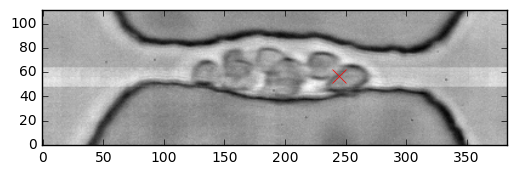

970
radius: 14.7488186793
aspect: 1.06459531737


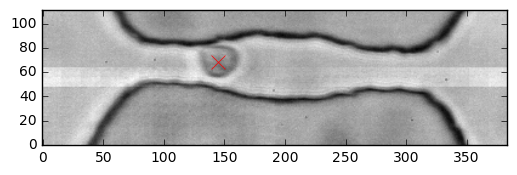

939
radius: 14.7561075979
aspect: 1.22897833592


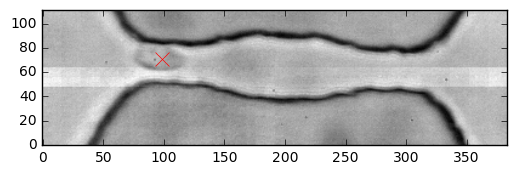

202
radius: 14.7737687985
aspect: 1.00955519573


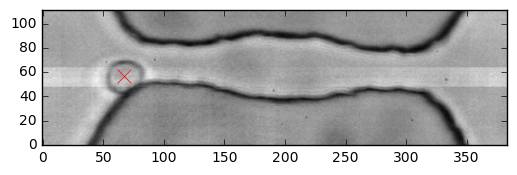

1181
radius: 14.7748221358
aspect: 1.39778351402


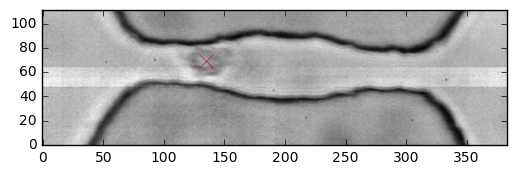

842
radius: 14.7819337588
aspect: 1.25658614275


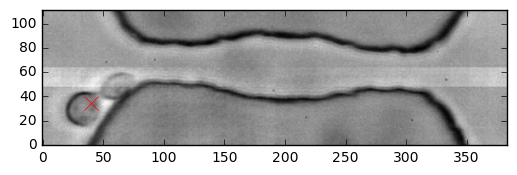

665
radius: 14.785693237
aspect: 1.32279733232


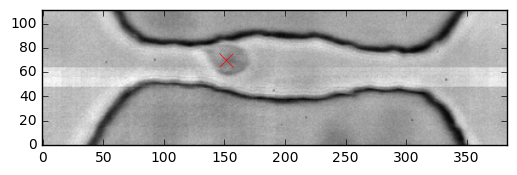

284
radius: 14.8045191615
aspect: 1.05979752446


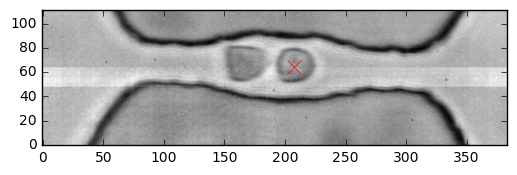

1090
radius: 14.8072497718
aspect: 1.78099204946


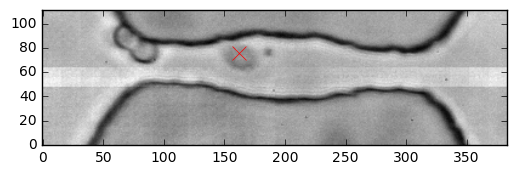

619
radius: 14.8501199904
aspect: 1.31072036933


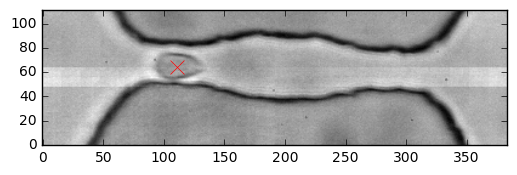

557
radius: 14.8595664765
aspect: 1.02846692643


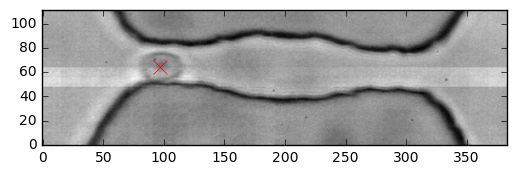

1154
radius: 14.8686202697
aspect: 1.58575774282


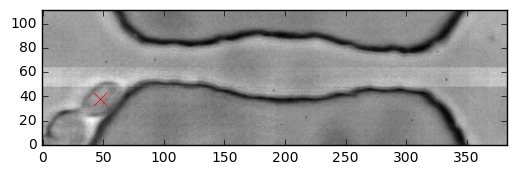

576
radius: 14.8711974597
aspect: 1.10387181131


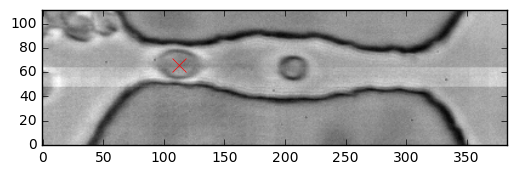

1103
radius: 14.9172163516
aspect: 1.23657950679


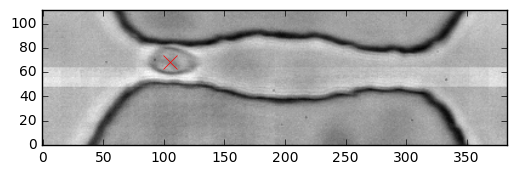

606
radius: 14.9296387456
aspect: 1.18424759435


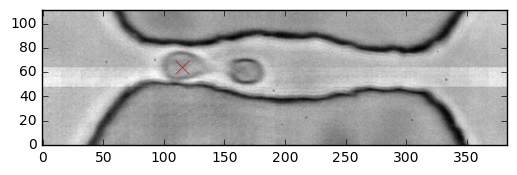

907
radius: 14.9389929065
aspect: 1.09122744938


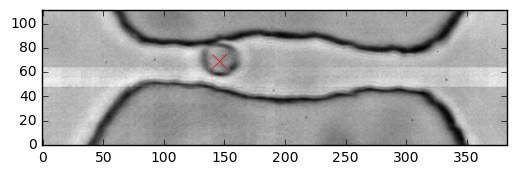

In [14]:
oi_indices = [687, 758, 564, 938, 1084, 327, 708, 970, 939, 202, 1181, 842, 665, 284, 1090, 619, 557, 1154, 576, 1103, 606, 907]
for oi_index in oi_indices:
    print oi_index

    print 'radius:', effective_radii[oi_index]
    print 'aspect:', aspect_ratios[oi_index]

    oi_event = oi_events[oi_index]
    ts = oi_event.get_tf()
    t = int((ts[-1] + ts[0])/2.)
    detection_index = t - ts[0]
    detection = oi_event._detections[detection_index]
    x = detection._px
    y = detection._py
    frame = oi_vid.get_frame(t)
    plt.scatter(x, y, marker = 'x', s = 100, color = 'red', lw = 0.5)

    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    plt.show()

### y-based filtering

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


value error
failed 225
value error
failed 308
value error
failed 428
value error
failed 1065


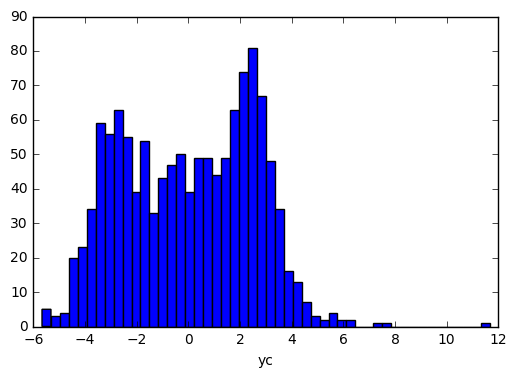

In [15]:
# Central cavity y-based filtering

yc_middles = []
yc_failed_indices = []

# Set yc_middle_min and max... These are bounds that we do not accept events outside of. Usually if there is
# a really bad fit, the detected yc value could be something like -60. This is unphysical, so we 
# manually introduce yc_middle_min and yc_middle_max to filter out unphysical values.
yc_middle_min = -25
yc_middle_max = 25

for i, oi_event in enumerate(oi_events):
    
    try:
        # Calculation sometimes fails, put in a 'try' block
        
        # Get positions of ellipses and convert to channel micron units
        xs = [ellipse[1] for ellipse in ellipsess[i]]
        ys = [ellipse[2] for ellipse in ellipsess[i]]
    
        
        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs)
        ycs = oi_stage.pixels_to_meters(ycs)
        

        # Interpolate the indices of x-positions
        #is_interp = scipy.interpolate.interp1d(xcs, range(len(xcs)))
    
    
        # Get the index closest to the middle of the channel
        #i_middle = int(is_interp(oi_stage._length_microns/2.))
        yc_middle = np.nanmean(ycs[(xcs > 10) & (xcs < 40)])
        
            
        #yc_middle = ycs[i_middle]
        
        
        if yc_middle > yc_middle_max or yc_middle < yc_middle_min or np.isnan(yc_middle):
            # The determined yc_middle is outside the manual bounds we set above; raise a ValueError
            # to exit try statement and go to except.
            print 'value error'
            raise ValueError
            
        yc_middles.append(yc_middle)

    
        
    except:
        # Calculation failed, add the index to the yc_failed_indices which will automatically be rejected
        # later on.
        print 'failed', i
        yc_failed_indices.append(i)
        yc_middles.append(-500)
    



    
# Apply offset to y so centered at 0... only count the successes
#yc_middles = np.array(yc_middles)
#yc_success_indices = np.array([i for i in range(len(oi_events)) if i not in yc_failed_indices])
#offset = -(np.max(yc_middles[yc_success_indices]) - np.abs(np.min(yc_middles[yc_success_indices])))/2.
#yc_middles = np.array(yc_middles)
#yc_middles = yc_middles + offset

yc_middles = np.array(yc_middles)

# Plot hist of all ys
plt.close()
#plt.hist(yc_middles[yc_success_indices], bins = 50)
plt.hist(yc_middles[(yc_middles >= yc_middle_min) & (yc_middles <= yc_middle_max)], bins = 50)
plt.xlabel('yc')
plt.show()



In [16]:
yc_threshold = 2
filtering_steps['yc cavity threshold'] = [yc_threshold]

keep_indices_y = np.where(np.abs(yc_middles) <= yc_threshold)[0]
keep_indices_y = [keep_index_y for keep_index_y in keep_indices_y if keep_index_y not in yc_failed_indices]

print 'length before', len(oi_events), 'length after', len(keep_indices_y)
print
print 'events retained (by y)', [ele for ele in np.argsort(yc_middles) if ele in keep_indices_y]

length before 1241 length after 556

events retained (by y) [493, 666, 705, 627, 280, 626, 229, 912, 327, 812, 651, 612, 455, 505, 116, 211, 437, 1203, 1088, 1096, 545, 57, 487, 1006, 593, 51, 268, 230, 475, 1, 441, 994, 315, 416, 763, 781, 693, 1095, 60, 661, 1196, 536, 501, 425, 878, 607, 1227, 670, 50, 203, 76, 202, 119, 557, 275, 655, 506, 1004, 474, 777, 923, 46, 1131, 1225, 740, 534, 278, 123, 295, 746, 421, 417, 582, 741, 822, 782, 911, 446, 331, 1156, 718, 185, 398, 949, 673, 1198, 644, 320, 1113, 1182, 706, 21, 149, 659, 596, 104, 33, 680, 837, 64, 473, 869, 513, 399, 932, 1184, 500, 8, 1188, 361, 209, 606, 737, 11, 383, 479, 1138, 608, 820, 910, 619, 532, 510, 90, 317, 103, 786, 222, 675, 1216, 1054, 925, 16, 400, 512, 265, 85, 995, 370, 1179, 1000, 638, 18, 215, 1031, 1101, 633, 489, 143, 287, 313, 732, 504, 1237, 950, 960, 422, 896, 453, 305, 381, 681, 495, 1026, 754, 86, 373, 511, 285, 653, 484, 63, 299, 346, 1114, 547, 23, 984, 454, 1233, 1230, 938, 270, 187, 742, 525, 90

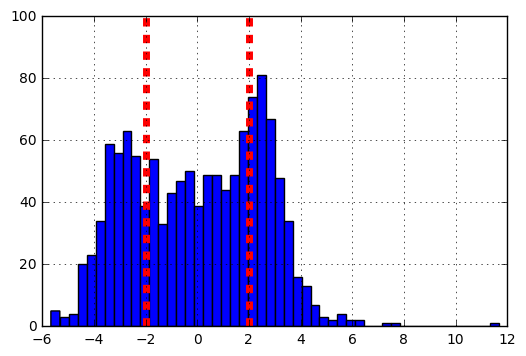

In [17]:
plt.hist(yc_middles[(yc_middles >= yc_middle_min) & (yc_middles <= yc_middle_max)], bins = 50)
plt.plot([-yc_threshold, -yc_threshold], [0,100], ls = '--', c = 'r', lw = 5)
plt.plot([yc_threshold, yc_threshold], [0,100], ls = '--', c = 'r', lw = 5)
plt.grid()
plt.show()

In [19]:
oi_index = 938
print 'radius', effective_radii[oi_index]
print 'aspect', aspect_ratios[oi_index]
print 'yc middle', yc_middles[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf, oi_index).to_html5_video())

radius 14.6955149105
aspect 1.16594468503
yc middle -0.62410273837


## Manual filtering
- Inspect the events that haven't been filtered out yet to make sure they are good.
- Add undesirable events to the 'manual_remove_indices' list

In [20]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_enter_exit)\
                                                     and (i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y))]

print 'keeping', len(keep_indices), '/', len(ellipsess), 'events before manual removal'
print 'events to be kept:', keep_indices

keeping 372 / 1241 events before manual removal
events to be kept: [2, 5, 6, 14, 16, 18, 21, 23, 24, 32, 33, 36, 41, 43, 44, 48, 49, 50, 52, 53, 54, 59, 60, 62, 63, 70, 72, 75, 78, 79, 80, 81, 84, 85, 86, 88, 90, 91, 95, 96, 97, 101, 102, 103, 104, 113, 116, 122, 123, 130, 138, 143, 149, 150, 151, 156, 159, 160, 164, 166, 167, 170, 173, 182, 183, 185, 187, 189, 194, 196, 197, 200, 202, 203, 208, 209, 210, 212, 215, 216, 217, 219, 221, 222, 230, 231, 240, 241, 248, 258, 259, 261, 265, 267, 268, 269, 270, 274, 275, 280, 282, 284, 286, 287, 295, 298, 299, 310, 313, 315, 316, 317, 325, 327, 328, 331, 334, 343, 346, 348, 360, 361, 362, 367, 369, 370, 373, 376, 383, 390, 392, 398, 399, 400, 401, 412, 414, 417, 419, 420, 422, 431, 437, 438, 441, 445, 446, 450, 454, 455, 456, 464, 467, 468, 474, 487, 492, 493, 500, 503, 504, 506, 507, 511, 518, 519, 526, 527, 531, 532, 536, 540, 545, 546, 547, 556, 557, 559, 563, 568, 570, 572, 576, 577, 581, 583, 591, 594, 596, 598, 599, 600, 603, 604, 606, 6

##### Inspect frame

In [ ]:
for oi_index in keep_indices:
    print oi_index

    print 'radius:', effective_radii[oi_index]
    print 'aspect:', aspect_ratios[oi_index]

    oi_event = oi_events[oi_index]
    ts = oi_event.get_tf()
    t = int((ts[-1] + ts[0])/2.)
    detection_index = t - ts[0]
    detection = oi_event._detections[detection_index]
    x = detection._px
    y = detection._py
    frame = oi_vid.get_frame(t)
    plt.scatter(x, y, marker = 'x', s = 100, color = 'red', lw = 0.5)

    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    plt.show()

In [ ]:
oi_index = 167
oi_event = oi_events[oi_index]
detection_index = int(len(oi_event._detections)/2.)
t = oi_event._detections[detection_index]._tf
frame = oi_vid.get_frame(t)



plt.close()
plt.imshow(frame, cmap = 'gray', origin = 'lower')
plt.scatter(oi_event._detections[detection_index]._px, oi_event._detections[detection_index]._py,\
            marker = 'x', c = 'red', lw = 3, s = 25)
plt.show()

In [22]:
manual_remove_indices = []

filtering_steps['manual removal'] = [len(manual_remove_indices)]

print 'manually removing indices', manual_remove_indices

keep_indices_manual = [i for i in range(len(oi_events)) if i not in manual_remove_indices]

manually removing indices []


## Filtering step

In [23]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_enter_exit)\
                                                     and (i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y)\
                                                    and (i in keep_indices_manual))]


print(keep_indices)
print
print
print('filtering ' + str(len(oi_events) - len(keep_indices)) + ' out of ' + str(len(oi_events)) + ' events')

[2, 5, 6, 14, 16, 18, 21, 23, 24, 32, 33, 36, 41, 43, 44, 48, 49, 50, 52, 53, 54, 59, 60, 62, 63, 70, 72, 75, 78, 79, 80, 81, 84, 85, 86, 88, 90, 91, 95, 96, 97, 101, 102, 103, 104, 113, 116, 122, 123, 130, 138, 143, 149, 150, 151, 156, 159, 160, 164, 166, 167, 170, 173, 182, 183, 185, 187, 189, 194, 196, 197, 200, 202, 203, 208, 209, 210, 212, 215, 216, 217, 219, 221, 222, 230, 231, 240, 241, 248, 258, 259, 261, 265, 267, 268, 269, 270, 274, 275, 280, 282, 284, 286, 287, 295, 298, 299, 310, 313, 315, 316, 317, 325, 327, 328, 331, 334, 343, 346, 348, 360, 361, 362, 367, 369, 370, 373, 376, 383, 390, 392, 398, 399, 400, 401, 412, 414, 417, 419, 420, 422, 431, 437, 438, 441, 445, 446, 450, 454, 455, 456, 464, 467, 468, 474, 487, 492, 493, 500, 503, 504, 506, 507, 511, 518, 519, 526, 527, 531, 532, 536, 540, 545, 546, 547, 556, 557, 559, 563, 568, 570, 572, 576, 577, 581, 583, 591, 594, 596, 598, 599, 600, 603, 604, 606, 607, 609, 610, 618, 622, 625, 626, 627, 633, 638, 639, 644, 648, 649

# Save
- Save the filtering parameters as well as the indices of the events to be kept

### Save filtering parameters and indices

In [24]:
output_base_path = oi_file.ellipse_base_path
output_file_path = output_base_path + date + '/' + particle + '/' + channel + '/' + file_index + '/filter'
print 'saving to ', output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    
    # Write filtering steps
    for filtering_step in filtering_steps:
        file_writer.writerow(['filter step', filtering_step, filtering_steps[filtering_step]])
        
    file_writer.writerow(['events'] + keep_indices)

saving to  /home/prestonh/Desktop/Research/cancer_cells/analysis/data/10-10-2017/293-T_0/10-20-10_1/0/filter
